In [22]:
from typing import TypedDict, List, Annotated
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

load_dotenv()

llm = init_chat_model("openai:gpt-4o-mini")

In [23]:
import operator


class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str
    ingredient_count: Annotated[int, operator.add]


class Ingredient(BaseModel):
    name: str
    quitantity: str
    unit: str


class IngredientsOutput(BaseModel):
    ingredients: List[Ingredient]

In [ ]:
def list_ingredients(state: State):
    print(f"\n{'=' * 50}")
    print(f"[list_ingredients] 호출 횟수: {state.get('ingredient_count', 0) + 1}")
    print(f"[list_ingredients] 요리: {state['dish']}")

    structured_llm = llm.with_structured_output(IngredientsOutput)
    response = structured_llm.invoke(
        f"{state['dish']} 음식을 만들기 위한 재료 이름을 나열해 주세요."
    )

    print(f"[list_ingredients] 재료 개수: {len(response.ingredients)}")
    print(f"[list_ingredients] 재료 목록: {[ing.name for ing in response.ingredients]}")

    return {
        "ingredients": response.ingredients,
        "ingredient_count": 1,  # operator.add로 누적됨
    }


def create_recipe(state: State):
    print(f"\n{'=' * 50}")
    print(f"[create_recipe] 실행")
    print(f"[create_recipe] 최종 재료 개수: {len(state['ingredients'])}")

    response = llm.invoke(
        f"{state['dish']} 요리를 만들기 위한 단계별 조리법을 작성해 주세요. 재료는 다음과 같습니다: {state['ingredients']}"
    )

    print(f"[create_recipe] 레시피 생성 완료 (길이: {len(response.content)} 자)")
    return {"recipe_steps": response.content}


def describe_plating(state: State):
    print(f"\n{'=' * 50}")
    print(f"[describe_plating] 실행")

    response = llm.invoke(
        f"{state['dish']}를 멋지게 플레이팅하는 방법 다음 레시피를 기반으로 설명해 주세요: {state['recipe_steps']}"
    )

    print(f"[describe_plating] 플레이팅 설명 완료 (길이: {len(response.content)} 자)")
    return {"plating_instructions": response.content}


def gate(state: State):
    ingredients = state.get("ingredients", [])
    ingredient_count = state.get("ingredient_count", 0)

    print(f"\n{'=' * 50}")
    print(f"[gate] 조건 검사")
    print(f"[gate] - 현재 호출 횟수: {ingredient_count}")
    print(f"[gate] - 재료 개수: {len(ingredients)}")

    # 호출 횟수가 5번 이상이면 강제로 다음 단계로
    if ingredient_count >= 5:
        print(f"[gate] ✓ 호출 횟수 {ingredient_count}회 도달 -> 다음 단계로 진행")
        return True

    # 재료가 너무 많거나 적으면 재시도
    if len(ingredients) > 8:
        print(
            f"[gate] ✗ 재료가 너무 많음 ({len(ingredients)}개) -> list_ingredients 재실행"
        )
        return False

    if len(ingredients) < 3:
        print(
            f"[gate] ✗ 재료가 너무 적음 ({len(ingredients)}개) -> list_ingredients 재실행"
        )
        return False

    # 정상 범위면 다음 단계로
    print(f"[gate] ✓ 재료 개수 적절 ({len(ingredients)}개) -> 다음 단계로 진행")
    return True

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)

graph_builder.add_edge(START, "list_ingredients")

# 조건부 분기: gate 함수 결과에 따라 다음 노드 결정
graph_builder.add_conditional_edges(
    "list_ingredients",
    gate,
    {
        True: "create_recipe",  # 조건 만족 시 레시피 생성으로
        False: "list_ingredients",  # 조건 불만족 시 재료 목록 다시 생성
    },
)

graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", END)

graph = graph_builder.compile()

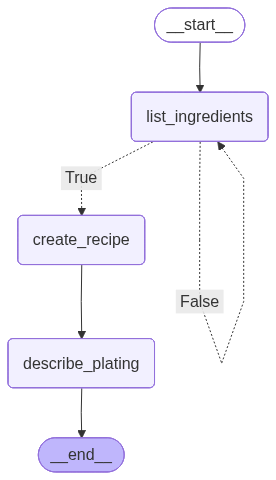

In [26]:
graph

In [ ]:
# ingredient_count 초기값 설정
result = graph.invoke(
    {
        "dish": "김치찌개",
        "ingredient_count": 0,  # 초기값 명시
    }
)

print(f"\n{'=' * 50}")
print(f"최종 결과:")
print(f"- 총 호출 횟수: {result['ingredient_count']}")
print(f"- 최종 재료 개수: {len(result['ingredients'])}")
print(f"\n재료 목록:")
for ing in result["ingredients"]:
    print(f"  - {ing.name}: {ing.quitantity} {ing.unit}")

result


[list_ingredients] 호출 횟수: 1
[list_ingredients] 요리: 김치찌개
[list_ingredients] 재료 개수: 10
[list_ingredients] 재료 목록: ['김치', '두부', '대파', '돼지고기', '고춧가루', '국간장', '마늘', '물', '소금', '후추']

[gate] 조건 검사
[gate] - 현재 호출 횟수: 1
[gate] - 재료 개수: 10
[gate] ✗ 재료가 너무 많음 (10개) -> list_ingredients 재실행

[list_ingredients] 호출 횟수: 2
[list_ingredients] 요리: 김치찌개
[list_ingredients] 재료 개수: 10
[list_ingredients] 재료 목록: ['김치', '돼지고기', '두부', '양파', '대파', '마늘', '고춧가루', '간장', '소금', '물']

[gate] 조건 검사
[gate] - 현재 호출 횟수: 2
[gate] - 재료 개수: 10
[gate] ✗ 재료가 너무 많음 (10개) -> list_ingredients 재실행

[list_ingredients] 호출 횟수: 3
[list_ingredients] 요리: 김치찌개
[list_ingredients] 재료 개수: 10
[list_ingredients] 재료 목록: ['김치', '두부', '돼지고기', '대파', '마늘', '물', '간장', '고춧가루', '소금', '후춧가루']

[gate] 조건 검사
[gate] - 현재 호출 횟수: 3
[gate] - 재료 개수: 10
[gate] ✗ 재료가 너무 많음 (10개) -> list_ingredients 재실행

[list_ingredients] 호출 횟수: 4
[list_ingredients] 요리: 김치찌개
[list_ingredients] 재료 개수: 10
[list_ingredients] 재료 목록: ['김치', '두부', '돼지고기', '양파', '대파', '마늘', '고춧가루', '

{'dish': '김치찌개',
 'ingredients': [Ingredient(name='김치', quitantity='2', unit='컵'),
  Ingredient(name='돼지고기(목살 또는 삼겹살)', quitantity='200', unit='그램'),
  Ingredient(name='두부', quitantity='1', unit='모'),
  Ingredient(name='양파', quitantity='1', unit='개'),
  Ingredient(name='대파', quitantity='1', unit='대'),
  Ingredient(name='마늘', quitantity='3', unit='쪽'),
  Ingredient(name='고춧가루', quitantity='2', unit='큰술'),
  Ingredient(name='국간장', quitantity='1', unit='큰술'),
  Ingredient(name='물', quitantity='4', unit='컵')],
 'recipe_steps': '김치찌개 요리를 위한 단계별 조리법을 아래에 작성하였습니다.\n\n### 재료 준비\n- 김치: 2컵\n- 돼지고기 (목살 또는 삼겹살): 200그램\n- 두부: 1모\n- 양파: 1개\n- 대파: 1대\n- 마늘: 3쪽\n- 고춧가루: 2 큰술\n- 국간장: 1 큰술\n- 물: 4컵\n\n### 조리법\n1. **재료 손질하기**:\n   - 김치는 먹기 좋은 크기로 썰어둡니다.\n   - 돼지고기는 적당한 크기로 자르고, 기름기가 많은 부분이 있다면 잘라내고 점을 내어줍니다.\n   - 두부는 1cm 두께로 썰어줍니다.\n   - 양파는 반으로 잘라서 채썰고, 대파는 어슷하게 썰어둡니다.\n   - 마늘은 다져서 준비합니다.\n\n2. **돼지고기 볶기**:\n   - 큰 냄비에 돼지고기를 넣고 중불로 볶습니다. 고기가 반쯤 익을 때까지 볶아주세요.\n\n3. **김치 추가하기**:\n   - 볶은 돼지고기에 손질한 김치를 넣